In [1]:
import dask
from dask import delayed
from dask.distributed import Client

import numpy as np
import json
import timeit
from tqdm import tqdm
from matplotlib import pyplot as plt
import os

from scipy.stats import truncnorm, uniform, expon, crystalball, norm
from scipy.integrate import quad
from scipy.optimize import minimize
from iminuit import Minuit, cost
from iminuit.cost import ExtendedUnbinnedNLL, ExtendedBinnedNLL
from sweights import SWeight

$N_{evs}$ in code is $\mu_{tot}$ in report


# Q2. Verifying PDF integration results

# Signal and Background Distributions

## Signal Distributions

### Signal Distribution on $ X $: $ g_s(X) $
According to the definition, $ g_s(X) $ follows a Crystal Ball distribution:

$$
g_s(X) = 
\begin{cases} 
N \cdot e^{-Z^2 / 2}, & Z > -\beta, \\
N \cdot \left( \frac{m}{\beta} \right)^m e^{-\beta^2 / 2} \left( \frac{m}{\beta} - \beta - Z \right)^{-m}, & Z \leq -\beta,
\end{cases}
$$

where:

$$
Z = \frac{X - \mu}{\sigma}
$$

is the standardized variable, and:

- $ N $: Normalization factor ensuring $ g_s(X) $ integrates to 1 over $ X \in [X_{\min}, X_{\max}] $.
- Parameters:
  - $ \mu = 3 $
  - $ \sigma = 0.3 $
  - $ \beta = 1 $
  - $ m = 1.4 $

### Signal Distribution on $ Y $: $ h_s(Y) $
The distribution $ h_s(Y) $ follows an exponential decay:

$$
h_s(Y) = \lambda e^{-\lambda Y},
$$

where:

- $ \lambda = 0.3 $: Decay constant.
- The distribution is truncated over $ Y \in [Y_{\min}, Y_{\max}] $.

---

## Background Distributions

### Background Distribution on $ X $: $ g_b(X) $
The background distribution $ g_b(X) $ is a uniform distribution:

$$
g_b(X) = \frac{1}{X_{\max} - X_{\min}},
$$

where $ X $ is truncated over $ X \in [X_{\min}, X_{\max}] $.

### Background Distribution on $ Y $: $ h_b(Y) $
The background distribution $ h_b(Y) $ is a truncated normal distribution:

$$
h_b(Y) = \frac{\phi\left( \frac{Y - \mu_b}{\sigma_b} \right)}{\Phi\left( \frac{Y_{\max} - \mu_b}{\sigma_b} \right) - \Phi\left( \frac{Y_{\min} - \mu_b}{\sigma_b} \right)},
$$

where:

- $ \phi(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2 / 2} $: Standard normal probability density function.
- $ \Phi(x) $: Standard normal cumulative distribution function.
- Parameters:
  - $ \mu_b = 0 $
  - $ \sigma_b = 2.5 $
- The distribution is truncated over $ Y \in [Y_{\min}, Y_{\max}] $.

---

## Joint Distributions

### Signal Joint Distribution: $ s(X, Y) $
Since $ X $ and $ Y $ are independent for the signal:

$$
s(X, Y) = g_s(X) \cdot h_s(Y).
$$

### Background Joint Distribution: $ b(X, Y) $
Since $ X $ and $ Y $ are independent for the background:

$$
b(X, Y) = g_b(X) \cdot h_b(Y).
$$

---

## Total Distribution
The total distribution is a weighted sum of the signal and background distributions:

$$
f(X, Y) = f \cdot s(X, Y) + (1 - f) \cdot b(X, Y),
$$

where:

- $ f = 0.6 $: Signal fraction.
- $ 1 - f = 0.4 $: Background fraction.

---

## Normalization Ranges
All distributions are defined within the following ranges:

$$
X \in [X_{\min}, X_{\max}] = [0, 5],
$$

$$
Y \in [Y_{\min}, Y_{\max}] = [0, 10].
$$


In [2]:
# Define the signal and background distributions in 2D

# parameters for signal and background distributions
mu = 3
sigma = 0.3
beta = 1
m = 1.4
f_signal = 0.6#
lambda_s = 0.3
mu_b = 0
sigma_b = 2.5

# Define valid ranges for X and Y
X_min, X_max = 0, 5
Y_min, Y_max = 0, 10


def smodel_x(x, mu, sigma, beta, m):
    '''Signal distribution on X: Truncated Crystal Ball distribution'''

    cb = crystalball(beta, m, loc=mu, scale=sigma) # Crystal Ball Distribution with predefined parameters
    norm_const = cb.cdf(X_max) - cb.cdf(X_min) # normalization constant
    return cb.pdf(x) / norm_const

def smodel_y(y, lambda_s):
    '''Singal distribution on Y: Truncated Exponential distribution'''
    
    expon_dist = expon(scale=1/lambda_s) # Exponential distribution 
    norm_const = expon_dist.cdf(Y_max) - expon_dist.cdf(Y_min) # normalization constant
    return expon_dist.pdf(y) / norm_const

def bmodel_x(x):
    '''Background distribution on X: Uniform distribution'''

    return uniform.pdf(x, loc=X_min, scale=X_max - X_min) # Uniform distribution 

def bmodel_y(y, mu_b, sigma_b):
    '''Background distribution on Y: Truncated Normal distribution'''
    
    a, b = (Y_min - mu_b) / sigma_b, (Y_max - mu_b) / sigma_b # Normalization constants
    trunc_norm = truncnorm(a, b, loc=mu_b, scale=sigma_b) # Truncated and Normalised Normal distribution
    
    return trunc_norm.pdf(y)

def smodel_xy(x, y, mu, sigma, beta, m, lambda_s):
    '''Joint signal distribution s(X, Y) = g_s(X) * h_s(Y)'''

    return  smodel_x(x, mu, sigma, beta, m) * smodel_y(y, lambda_s)

def bmodel_xy(x, y, mu_b, sigma_b):
    '''Joint background distribution b(X, Y) = g_b(X) * h_b(Y)'''

    return bmodel_x(x) * bmodel_y(y, mu_b, sigma_b)

def model(x, y, f_signal, mu, sigma, beta, m, lambda_s, mu_b, sigma_b):
    '''Joint distribution f(X, Y) = f_signal * s(X, Y) + (1 - f_signal) * b(X, Y)'''
    return f_signal * smodel_xy(x, y, mu, sigma, beta, m, lambda_s) + (1 - f_signal) * bmodel_xy(x, y, mu_b, sigma_b)

def density(xy, f_signal, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, N_evs):
    '''Density function for the model, matching the signature of the ExtendedUnbinnedNLL cost function'''
    x, y = xy  # Unpack the input
    Ns = N_evs * f_signal
    Nb = N_evs * (1 - f_signal)
    return N_evs, Ns * smodel_xy(x, y, mu, sigma, beta, m, lambda_s) + Nb * bmodel_xy(x, y, mu_b, sigma_b)


In [3]:
# Integrate the signal and background distributions to check if they are normalized

def integrate_1d(func, var_min, var_max, args=()):
    """Perform 1D integration of the given function."""
    result, _ = quad(func, var_min, var_max, args=args)
    return result

def integrate_2d(func, x_min, x_max, y_min, y_max, args=()):
    """
    Perform 2D integration of the given function f(x, y).
    Integrate over x and then over y.
    """
    def integrand(y, *args):
        integral_result, _ = quad(func, x_min, x_max, args=(y,) + args)
        return integral_result
    total_integral, _ = quad(integrand, y_min, y_max, args=args)
    return total_integral


# Test the integrals
norm_smodel_x = integrate_1d(smodel_x, X_min, X_max, args=(mu, sigma, beta, m))
print(f"Integral of g_s(X) over [{X_min}, {X_max}]: {norm_smodel_x}")

norm_smodel_y = integrate_1d(smodel_y, Y_min, Y_max, args=(lambda_s,))
print(f"Integral of h_s(Y) over [{Y_min}, {Y_max}]: {norm_smodel_y}")

norm_bmodel_x = integrate_1d(bmodel_x, X_min, X_max)
print(f"Integral of g_b(X) over [{X_min}, {X_max}]: {norm_bmodel_x}")

norm_bmodel_y = integrate_1d(bmodel_y, Y_min, Y_max, args=(mu_b, sigma_b))
print(f"Integral of h_b(Y) over [{Y_min}, {Y_max}]: {norm_bmodel_y}")

norm_smodel_xy = integrate_2d(smodel_xy, X_min, X_max, Y_min, Y_max, args=(mu, sigma, beta, m, lambda_s))
print(f"Integral of s(X, Y) over X:[{X_min}, {X_max}], Y:[{Y_min}, {Y_max}]: {norm_smodel_xy}")

norm_bmodel_xy = integrate_2d(bmodel_xy, X_min, X_max, Y_min, Y_max, args=(mu_b, sigma_b))
print(f"Integral of b(X, Y) over X:[{X_min}, {X_max}], Y:[{Y_min}, {Y_max}]: {norm_bmodel_xy}")

norm_model = integrate_2d(model, X_min, X_max, Y_min, Y_max, args=(f_signal, mu, sigma, beta, m, lambda_s, mu_b, sigma_b))
print(f"Integral of f(X, Y) over X:[{X_min}, {X_max}], Y:[{Y_min}, {Y_max}]: {norm_model}")


Integral of g_s(X) over [0, 5]: 1.0000000376260723
Integral of h_s(Y) over [0, 10]: 1.0
Integral of g_b(X) over [0, 5]: 1.0000000000000002
Integral of h_b(Y) over [0, 10]: 1.0
Integral of s(X, Y) over X:[0, 5], Y:[0, 10]: 1.0000000376260723
Integral of b(X, Y) over X:[0, 5], Y:[0, 10]: 1.0
Integral of f(X, Y) over X:[0, 5], Y:[0, 10]: 1.0000000225756431


In [4]:
# # Testing the normalization of the model with different parameters
# # All integral are close to 1, all tests passed

# # Define a set of different parameters to test normalization
# test_params = [
#     {"mu": 2.5, "sigma": 0.4, "beta": 0.8, "m": 2.0, "f_signal": 0.7, "lambda_s": 0.2, "mu_b": -0.5, "sigma_b": 3.0},
#     {"mu": 3.2, "sigma": 0.2, "beta": 1.2, "m": 1.8, "f_signal": 0.5, "lambda_s": 0.5, "mu_b": 1.0, "sigma_b": 2.0},
#     {"mu": 2.8, "sigma": 0.5, "beta": 0.9, "m": 1.5, "f_signal": 0.6, "lambda_s": 0.4, "mu_b": -1.0, "sigma_b": 2.8},
# ]

# # Test each set of parameters
# for i, params in enumerate(test_params):
#     norm_smodel_xy = integrate_2d(smodel_xy, X_min, X_max, Y_min, Y_max,
#                                   args=(params["mu"], params["sigma"], params["beta"], params["m"], params["lambda_s"]))
#     norm_bmodel_xy = integrate_2d(bmodel_xy, X_min, X_max, Y_min, Y_max,
#                                   args=(params["mu_b"], params["sigma_b"]))
#     norm_model = integrate_2d(model, X_min, X_max, Y_min, Y_max,
#                               args=(params["f_signal"], params["mu"], params["sigma"], params["beta"], params["m"],
#                                     params["lambda_s"], params["mu_b"], params["sigma_b"]))
    
#     print(f"Test {i+1}:")
#     print(f"  Integral of s(X, Y) over X:[{X_min}, {X_max}], Y:[{Y_min}, {Y_max}]: {norm_smodel_xy}")
#     print(f"  Integral of b(X, Y) over X:[{X_min}, {X_max}], Y:[{Y_min}, {Y_max}]: {norm_bmodel_xy}")
#     print(f"  Integral of f(X, Y) over X:[{X_min}, {X_max}], Y:[{Y_min}, {Y_max}]: {norm_model}")
#     print()


# Q3. Plotting PDFs

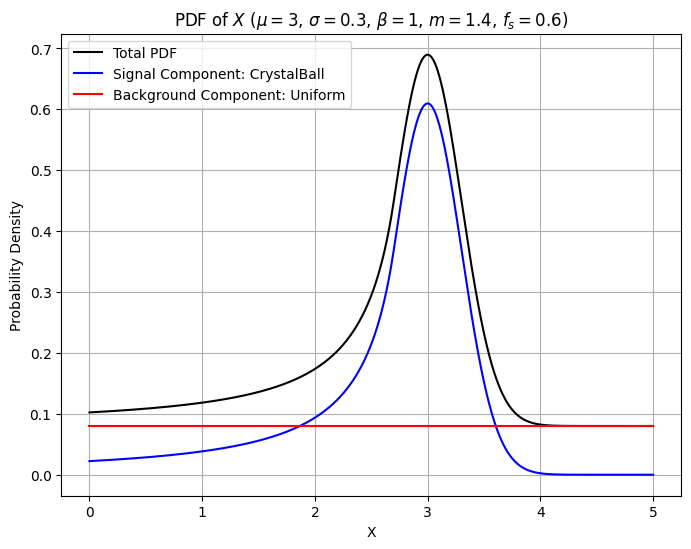

In [5]:
# Plot the PDFs of X

x_vals = np.linspace(X_min, X_max, 1000)

f_signal_X = f_signal * smodel_x(x_vals, mu, sigma, beta, m)
f_background_X = (1 - f_signal) * bmodel_x(x_vals)
f_X = f_signal_X + f_background_X

plt.figure(figsize=(8, 6))
plt.plot(x_vals, f_X, label='Total PDF', color='black')
plt.plot(x_vals, f_signal_X, label='Signal Component: CrystalBall', color='blue')
plt.plot(x_vals, f_background_X, label='Background Component: Uniform', color='red')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title(rf'PDF of $X$ ($\mu={mu}$, $\sigma={sigma}$, $\beta={beta}$, $m={m}$, $f_s={f_signal}$)')
plt.legend()
plt.grid(True)
plt.show()


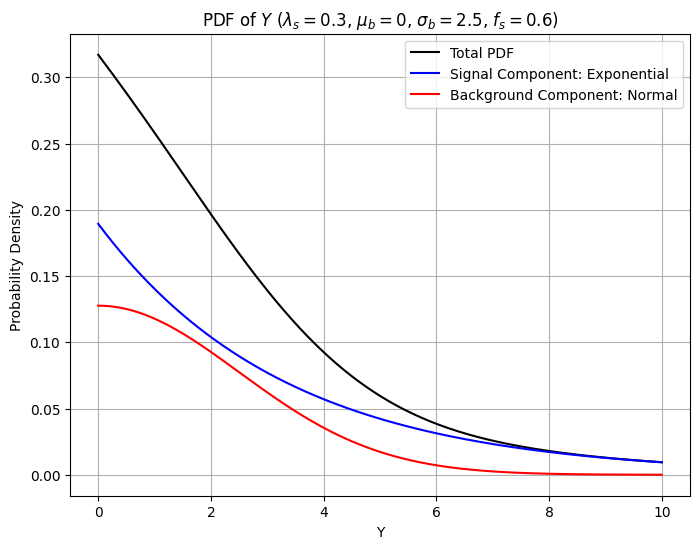

In [6]:
# Plot the PDFs of Y

y_vals = np.linspace(Y_min, Y_max, 1000)

f_signal_Y = f_signal * smodel_y(y_vals, lambda_s)
f_background_Y = (1 - f_signal) * bmodel_y(y_vals, mu_b, sigma_b)
f_Y = f_signal_Y + f_background_Y

plt.figure(figsize=(8, 6))
plt.plot(y_vals, f_Y, label='Total PDF', color='black')
plt.plot(y_vals, f_signal_Y, label='Signal Component: Exponential', color='blue')
plt.plot(y_vals, f_background_Y, label='Background Component: Normal', color='red')
plt.xlabel('Y')
plt.ylabel('Probability Density')
plt.title(rf'PDF of $Y$ ($\lambda_s={lambda_s}$, $\mu_b={mu_b}$, $\sigma_b={sigma_b}$, $f_s={f_signal}$)')
plt.legend()
plt.grid(True)
plt.show()




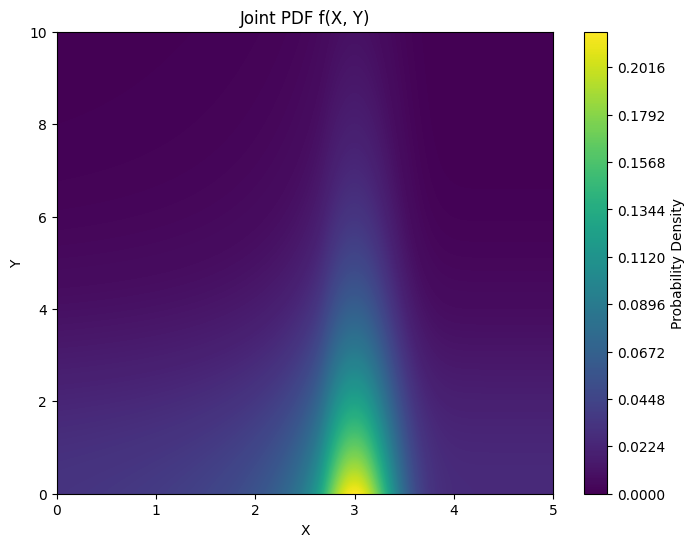

In [7]:
# Plot the joint PDF f(X, Y)

X_grid, Y_grid = np.meshgrid(x_vals, y_vals)  # Create the grid for X and Y

Z = model(X_grid, Y_grid, f_signal, mu, sigma, beta, m, lambda_s, mu_b, sigma_b)

plt.figure(figsize=(8, 6))
plt.contourf(X_grid, Y_grid, Z, levels=300, cmap='viridis')  
plt.colorbar(label='Probability Density')  
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Joint PDF f(X, Y)')
plt.show()


# Q4. Data Generation and Maximum Likelihood Estimation

# Extended Maximum Likelihood Function

The complete extended maximum likelihood function is given by:

$$
\mathcal{L}(\theta; \text{data}) = \frac{e^{-\mu_{\text{total}}} \mu_{\text{total}}^N}{N!} \prod_{i=1}^{N} \left[ f \cdot s(X_i, Y_i; \theta_s) + (1 - f) \cdot b(X_i, Y_i; \theta_b) \right]
$$


### Signal Distribution
The signal distribution is defined as:

$$
s(X, Y; \theta_s) = g_s(X) h_s(Y) = \text{CrystalBall}(X; \mu, \sigma, \beta, m) \cdot \lambda e^{-\lambda Y}
$$

### Background Distribution
The background distribution is defined as:

$$
b(X, Y; \theta_b) = g_b(X) h_b(Y) = \text{Uniform}(X; 0, 5) \cdot \text{TruncatedNormal}(Y; \mu_b, \sigma_b)
$$

### Parameters
- $\boldsymbol{\mu}$: Mean of the Crystal Ball function. (to be fitted)
- $\boldsymbol{\sigma}$: Scale of the Crystal Ball function. (to be fitted)
- $\boldsymbol{\beta}, \boldsymbol{m}$: Shape parameters of the Crystal Ball function. (to be fitted)
- $\boldsymbol{\lambda}$: Decay constant of the signal's exponential distribution. (to be fitted)
- $\boldsymbol{\mu_b}, \boldsymbol{\sigma_b}$: Mean and standard deviation of the background truncated normal distribution. (to be fitted)
- $\boldsymbol{f}$: Signal fraction. (to be fitted)
- $\boldsymbol{\mu_{\text{total}}}$: Total expected number of events. (to be fitted)
- $\boldsymbol{X_i}, \boldsymbol{Y_i}$: Observed values of the random variables $\boldsymbol{X}$ and $\boldsymbol{Y}$ for the $i$-th event. (observed data, not fitted)
- $\boldsymbol{\mu_{tot}}$: Total number of observed events in the dataset. (fixed, determined by the data)

In this case, number of observation $N$ is not generated from Poisson distribution but it's still meaningful to estimate $\mu_{tot}$ for comparision purposes

In [8]:
def generate_dataset_accrej(N_total, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=True):
    """
    Utilising accept rejection method, generate a dataset of N_total events using signal and background model distributions, 

    Parameters:
        N_total (int): Total number of events.
        f_signal (float): Fraction of signal events.
        poiss (bool): Apply Poisson fluctuations to event counts.

    Returns:
        tuple: 
            - np.ndarray: Dataset of shape (2, N_total) where rows represent X and Y coordinates.
            - float: Generation efficiency (accepted samples / generated samples).
    """
    # Determine signal and background event counts
    N_signal = int(N_total * f_signal)
    N_background = N_total - N_signal
    if poiss:
        N_signal = np.random.poisson(N_signal)
        N_background = np.random.poisson(N_background)

    # Track total generated samples and accepted samples
    total_generated = 0
    total_accepted = 0

    # Generate signal events
    X_signal, Y_signal = [], []
    while len(X_signal) < N_signal:
        x_sample = np.random.uniform(X_min, X_max, size=N_signal - len(X_signal))
        y_sample = np.random.uniform(Y_min, Y_max, size=N_signal - len(Y_signal))
        total_generated += len(x_sample)  # Add the number of generated samples
        accept = np.random.uniform(0, 1, size=len(x_sample)) < smodel_xy(x_sample, y_sample, mu, sigma, beta, m, lambda_s)
        accepted_samples = x_sample[accept]
        X_signal.extend(accepted_samples)
        Y_signal.extend(y_sample[accept])
        total_accepted += len(accepted_samples)  # Count the accepted samples

    # Generate background events
    X_background, Y_background = [], []
    while len(X_background) < N_background:
        x_sample = np.random.uniform(X_min, X_max, size=N_background - len(X_background))
        y_sample = np.random.uniform(Y_min, Y_max, size=N_background - len(Y_background))
        total_generated += len(x_sample)  # Add the number of generated samples
        accept = np.random.uniform(0, 1, size=len(x_sample)) < bmodel_xy(x_sample, y_sample, mu_b, sigma_b)
        accepted_samples = x_sample[accept]
        X_background.extend(accepted_samples)
        Y_background.extend(y_sample[accept])
        total_accepted += len(accepted_samples)  # Count the accepted samples

    # Calculate generation efficiency
    efficiency = total_accepted / total_generated if total_generated > 0 else 0

    # Combine and return the dataset and efficiency
    X_total = np.concatenate([X_signal, X_background])
    Y_total = np.concatenate([Y_signal, Y_background])
    return np.array([X_total, Y_total]), efficiency


def generate_dataset(N_total, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=True):
    """
    Utiling ppf, generate a dataset of N_total events using the PPF method, based on signal and background models.

    Parameters:
        N_total (int): Total number of events.
        mu (float): Mean of the signal X distribution.
        sigma (float): Standard deviation of the signal X distribution.
        beta (float): Beta parameter for the signal's Crystal Ball distribution.
        m (float): m parameter for the signal's Crystal Ball distribution.
        lambda_s (float): Exponential parameter for the signal Y distribution.
        mu_b (float): Mean of the background Y normal distribution.
        sigma_b (float): Standard deviation of the background Y normal distribution.
        f_signal (float): Fraction of signal events.
        poiss (bool): Whether to apply Poisson fluctuation to the event count.

    Returns:
        np.ndarray: A dataset of shape (2, N_total), where the first row contains X coordinates
                    and the second row contains Y coordinates.
    """
    # Determine signal and background event counts
    N_signal = int(N_total * f_signal)
    N_background = N_total - N_signal
    if poiss:
        N_signal = np.random.poisson(N_signal)
        N_background = np.random.poisson(N_background)
    
    # 1. Generate signal X, using truncated Crystal Ball distribution
    cb = crystalball(beta, m, loc=mu, scale=sigma)
    cdf_x_min = cb.cdf(X_min)
    cdf_x_max = cb.cdf(X_max)
    u_x = np.random.uniform(cdf_x_min, cdf_x_max, N_signal)
    X_signal = cb.ppf(u_x)
    
    # 2. Generate signal Y, using truncated Exponential distribution
    expon_dist = expon(scale=1/lambda_s)
    cdf_y_min = expon_dist.cdf(Y_min)
    cdf_y_max = expon_dist.cdf(Y_max)
    u_y = np.random.uniform(cdf_y_min, cdf_y_max, N_signal)
    Y_signal = expon_dist.ppf(u_y)
    
    # 3. Generate background X, using uniform distribution
    uniform_dist = uniform(loc=X_min, scale=X_max - X_min)
    X_background = uniform_dist.ppf(np.random.uniform(0, 1, N_background))
    
    # 4. Generate background Y, using truncated Normal distribution
    a, b = (Y_min - mu_b) / sigma_b, (Y_max - mu_b) / sigma_b
    trunc_norm = truncnorm(a, b, loc=mu_b, scale=sigma_b)
    u_b = np.random.uniform(trunc_norm.cdf(Y_min), trunc_norm.cdf(Y_max), N_background)
    Y_background = trunc_norm.ppf(u_b)
    
    # Combine and return as shape (2, N_total
    X_total = np.concatenate([X_signal, X_background])
    Y_total = np.concatenate([Y_signal, Y_background])
    
    return np.array([X_total, Y_total])

N_total = 100000

# dataset, efficiency = generate_dataset_accrej(N_total, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=False)
dataset = generate_dataset(N_total, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=False)

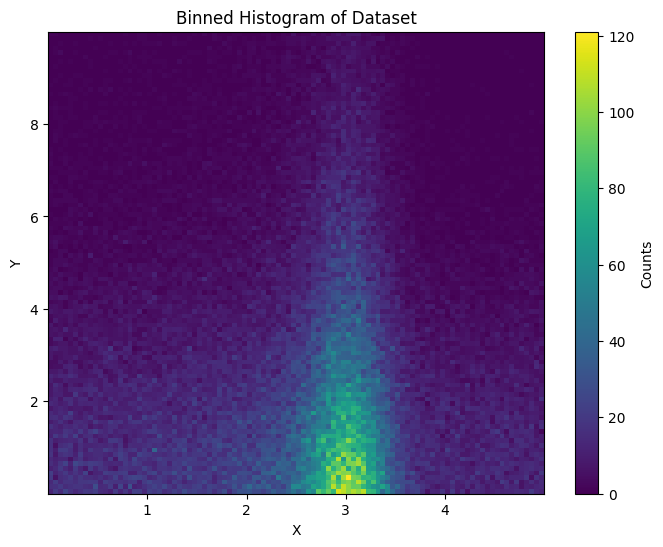

In [9]:
# Plot the generated dataset on histogram for verification

bins_x = 100  
bins_y = 100  

plt.figure(figsize=(8, 6))
hist, xedges, yedges, im = plt.hist2d(dataset[0], dataset[1], bins=[bins_x, bins_y], cmap='viridis')

cbar = plt.colorbar(im)
cbar.set_label('Counts')

plt.title('Binned Histogram of Dataset')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()


In [10]:
# Perform Maximum Likelihood Estimate (MLE) on given data and parameters

def mle_fit(dataset, density, N_total, params):
    """
    Perform Maximum Likelihood Estimate (MLE) on given data and parameters.

    Parameters:
        dataset (np.ndarray): The dataset containing xdata and ydata.
        density (function): The density function to be used for MLE.
        N_total (int): Total number of events in the dataset.
        params (dict): Dictionary containing initial guesses for parameters.

    Returns:
        Minuit: The optimized Minuit object containing the fitted parameters and uncertainties.
    """
    
    xdata, ydata = dataset[0], dataset[1] # Extract xdata and ydata from the 
    
    n2ll = ExtendedUnbinnedNLL((xdata, ydata), density) # Extended Unbinned Negative Likelihood function
    
    # Initialize Minuit optimizer
    mi = Minuit( 
        n2ll,
        **params,  # Parse the parameters dictionary
        N_evs=N_total,  # Add N_total explicitly
    )
    
    # Set parameter limits
    mi.limits["f_signal"] = (0, 1)        # 0 < f_signal < 1
    mi.limits["mu"] = (X_min, X_max)      # X_min < mu < X_max
    mi.limits["sigma"] = (0, 5)
    mi.limits["beta"] = (0, 2)            # beta > 0
    mi.limits["m"] = (1, 2)               # m > 1
    mi.limits["lambda_s"] = (0, 5)
    mi.limits["mu_b"] = (Y_min, Y_max)    # Ymin < mu_b < Ymax
    mi.limits["sigma_b"] = (0, 5)
    mi.limits["N_evs"] = (0, 3 * N_total)

    mi.simplex()
    mi.migrad() # Perform the fit
    
    return mi

params = {
    "f_signal": 0.6,
    "mu": 3,
    "sigma": 0.3,
    "beta": 1,
    "m": 1.4,
    "lambda_s": 0.3,
    "mu_b": 0,
    "sigma_b": 2.5
}

dataset = generate_dataset(N_total, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=False)
mi = mle_fit(dataset, density, N_total, params)

print("Fitted parameters:")
for name, value, error in zip(mi.parameters, mi.values, mi.errors):
    print(f"{name} = {value:.4f} ± {error:.4f}")

mi

Fitted parameters:
f_signal = 0.5996 ± 0.0037
mu = 2.9957 ± 0.0026
sigma = 0.3004 ± 0.0024
beta = 1.0273 ± 0.0227
m = 1.3237 ± 0.0596
lambda_s = 0.2972 ± 0.0021
mu_b = 0.0913 ± 0.1126
sigma_b = 2.4487 ± 0.0536
N_evs = 99999.8850 ± 316.2271


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.46e+06                  │             Nfcn = 1046              │
│ EDM = 6.35e-05 (Goal: 0.0002)    │           time = 18.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f_signal │   0.600   │   0.004   │            │            │    0    │    1    │       │
│ 1 │ mu       │  2.9957   │  0.0026   │            │            │    0    │    5    │       │
│ 2 │ sigma    │  0.3004   │  0.0024   │            │            │    0    │    5    │       │
│ 3 │ beta     │   1.027   │   0.023   │            │            │    0    │    2    │       │
│ 4 │ m        │   1.32    │   0.06    │            │            │    1    │    2    │       │
│ 5 │ lambda_s │  0.2972   │  0.0021   │            │            │    0    │    5    │       │
│ 6 │ mu_b     │   0.09    │   0.11    │            │            │    0    │   10    │       │
│ 7 │ sigma_b  │   2.45    │   0.05    │            │            │    0    │    5    │       │
│ 8 │ N_evs    │ 100.00e3  │  0.32e3   │            │            │    0    │ 300000  │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │  f_signal        mu     sigma      beta         m  lambda_s      mu_b   sigma_b     N_evs │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│ f_signal │  1.33e-05     -0e-6      3e-6  0.009e-3 -0.084e-3      2e-6  0.119e-3 -0.063e-3         0 │
│       mu │     -0e-6  6.55e-06     -3e-6    -30e-6     51e-6     -0e-6     -6e-6      3e-6      0e-6 │
│    sigma │      3e-6     -3e-6  5.93e-06     25e-6    -51e-6      0e-6     38e-6    -20e-6      0e-6 │
│     beta │  0.009e-3    -30e-6     25e-6  0.000517   -1.2e-3      1e-6    0.2e-3   -0.1e-3        -0 │
│        m │ -0.084e-3     51e-6    -51e-6   -1.2e-3   0.00357    -12e-6    -0.001    0.0006     0.000 │
│ lambda_s │      2e-6     -0e-6      0e-6      1e-6    -12e-6  4.26e-06     24e-6     -3e-6      0e-6 │
│     mu_b │  0.119e-3     -6e-6     38e-6    0.2e-3    -0.001     24e-6    0.0127   -0.0058     0.000 │
│  sigma_b │ -0.063e-3      3e-6    -20e-6   -0.1e-3    0.0006     -3e-6   -0.0058   0.00287   -0.0000 │
│    N_evs │         0      0e-6      0e-6        -0     0.000      0e-6     0.000   -0.0000     1e+05 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [11]:
mi.covariance.correlation()

,f_signal,mu,sigma,beta,m,lambda_s,mu_b,sigma_b,N_evs
f_signal,1,0,0.3,0.1,-0.4,0.3,0.3,-0.3,0
mu,0,1,-0.5,-0.5,0.3,0,0,0,0
sigma,0.3,-0.5,1,0.5,-0.3,0.1,0.1,-0.2,0
beta,0.1,-0.5,0.5,1,-0.9,0,0.1,-0.1,0
m,-0.4,0.3,-0.3,-0.9,1,-0.1,-0.2,0.2,0
lambda_s,0.3,0,0.1,0,-0.1,1,0.1,0,0
mu_b,0.3,0,0.1,0.1,-0.2,0.1,1,-1,0
sigma_b,-0.3,0,-0.2,-0.1,0.2,0,-1,1,0
N_evs,0,0,0,0,0,0,0,0,1


In [ ]:
# # WARNING: This cell takes 20 to 30 minutes to run
# # Decrease N_samples to reduce the time taken (N_samples = 10000 takes 3 to 4 minutes, N_samples = 1000 takes about 2 minutes)

# # Measure the time taken for various steps in the process

# N_samples = 100000

# # (i) Benchmark for np.random.normal
# start_time_normal = timeit.default_timer()
# for _ in range(100):
#     np.random.normal(size=N_samples)
# end_time_normal = timeit.default_timer()
# time_normal = (end_time_normal - start_time_normal) / 100

# print(f"Time for np.random.normal(size=100000): {time_normal:.6f} seconds\n")

# # (ii) Benchmark for generating the dataset 100 times
# start_time_generate = timeit.default_timer()
# for _ in range(100):
#     trail_datast = generate_dataset(N_samples, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=False)
# end_time_generate = timeit.default_timer()
# time_generate_dataset = (end_time_generate - start_time_generate) / 100

# print(f"Time for generating the dataset with ppf of {N_samples} samples(average over 100): {time_generate_dataset:.6f} seconds")
# print(f"Relative time for generating dataset: {time_generate_dataset / time_normal:.2f}x\n")

# # (iii) Benchmark for generating the dataset with accept reject method 100 times
# start_time_generate_accrej = timeit.default_timer()
# efficiencies = []
# for _ in range(100):
#     trail_datast, efficiency  = generate_dataset_accrej(N_samples, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=False)
#     efficiencies.append(efficiency)
# mean_efficiency = sum(efficiencies)/len(efficiencies)
# end_time_generate_accrej = timeit.default_timer()
# time_generate_dataset_accrej = (end_time_generate_accrej - start_time_generate_accrej) / 100  
# print(f"Efficiency of accept-reject method: {mean_efficiency:.4f}")
# print(f"Time for generating the dataset with accept-reject of {N_samples} samples(average over 100): {time_generate_dataset_accrej:.6f} seconds")
# print(f"Relative time for generating dataset: {time_generate_dataset_accrej / time_normal:.2f}x\n")

# # (iv) Benchmark for performing the fit
# start_time_fit = timeit.default_timer()
# for _ in range(100):    
#     mle_fit(trail_datast, density, N_samples, params)
# end_time_fit = timeit.default_timer()
# time_fit = (end_time_fit - start_time_fit)/100

# print(f"Time for performing the fit(averaged over 100) : {time_fit:.6f} seconds")
# print(f"Relative time for performing fit: {time_fit / time_normal:.2f}x")

# # new: Store results in a dictionary
# time_results = {
#     "Timing": {
#         "np_random_normal": time_normal,
#         "generate_dataset_ppf": time_generate_dataset,
#         "generate_dataset_accrej": time_generate_dataset_accrej,
#         "fit": time_fit
#     },
#     "Relative_Times": {
#         "ppf_vs_normal": time_generate_dataset / time_normal,
#         "accrej_vs_normal": time_generate_dataset_accrej / time_normal,
#         "fit_vs_normal": time_fit / time_normal
#     },
#     "Efficiency": {
#         "accept_reject_efficiency": mean_efficiency
#     }
# }

# os.makedirs("results", exist_ok=True)
# with open("results/time_benchmark_results.json", "w") as json_file:
#     json.dump(time_results, json_file, indent=4)


In [13]:
N_samples = 100000

with open("results/time_benchmark_results.json", "r") as json_file:
    time_results = json.load(json_file)


print(f"Time for np.random.normal(size={N_samples}): {time_results['Timing']['np_random_normal']:.6f} seconds\n")

print(f"Time for generating the dataset with ppf of {N_samples} samples (average over 100): {time_results['Timing']['generate_dataset_ppf']:.6f} seconds")
print(f"Relative time for generating dataset with ppf: {time_results['Relative_Times']['ppf_vs_normal']:.2f}x\n")

print(f"Time for generating the dataset with accept-reject of {N_samples} samples (average over 100): {time_results['Timing']['generate_dataset_accrej']:.6f} seconds")
print(f"Relative time for generating dataset with accept-reject: {time_results['Relative_Times']['accrej_vs_normal']:.2f}x")
print(f"Efficiency of accept-reject method: {time_results['Efficiency']['accept_reject_efficiency']:.4f}\n")

print(f"Time for performing the fit (averaged over 100): {time_results['Timing']['fit']:.6f} seconds")
print(f"Relative time for performing fit: {time_results['Relative_Times']['fit_vs_normal']:.2f}x\n")



Time for np.random.normal(size=100000): 0.001326 seconds

Time for generating the dataset with ppf of 100000 samples (average over 100): 0.023293 seconds
Relative time for generating dataset with ppf: 17.57x

Time for generating the dataset with accept-reject of 100000 samples (average over 100): 1.580474 seconds
Relative time for generating dataset with accept-reject: 1192.00x
Efficiency of accept-reject method: 0.0200

Time for performing the fit (averaged over 100): 44.200038 seconds
Relative time for performing fit: 33335.88x



In [14]:
# # WARNING: This cell takes about 45 minutes to run and requires high CPU usage
# # Reduce `experiments` to reduce the time taken

# # simple experiment to check if the true parameter values are within the estimated range

# N_samples = 100000
# client = Client(n_workers=5, threads_per_worker=1) 

# # Define a function to run one MLE fit and check if true parameter values are within the error bounds
# @delayed
# def run_mle_and_check(N_samples, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, params):
#     # Generate dataset
#     trail_datast = generate_dataset(N_samples, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=False)
    
#     # Run MLE fit
#     mi = mle_fit(trail_datast, density, N_samples, params)
    
#     true_value_hits_local = {param: 0 for param in params}
#     true_value_hits_local['N_evs'] = 0  # Add a counter for N_evs within the range
    
#     # Check if true parameter values lie within the error bounds
#     for name, value, error in zip(mi.parameters, mi.values, mi.errors):
#         if name in params:
#             true_value = params[name]  # True value from initial parameters
#             if value - error <= true_value <= value + error:
#                 true_value_hits_local[name] += 1
        
#         # Check if N_samples is within the estimated N_evs ± error
#         if name == 'N_evs':
#             N_evs_value = value
#             N_evs_error = error
#             if N_evs_value - N_evs_error <= N_samples <= N_evs_value + N_evs_error:
#                 true_value_hits_local['N_evs'] += 1
    
#     return true_value_hits_local

# tasks = []
# expermiments = 500
# for _ in range(expermiments): # Add delayed tasks to the list for parallel execution
#     task = run_mle_and_check(N_samples, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, params)
#     tasks.append(task)


# results = dask.compute(*tasks) # Compute all tasks in parallel

# true_value_hits = {param: 0 for param in params} # dictionary to accumulate counts from all tasks
# true_value_hits['N_evs'] = 0  


# for result in results: # Combine results from all tasks
#     for name, hits in result.items():
#         true_value_hits[name] += hits

# # Print the results
# print("True value hits in the MLE fits:")
# for name, hits in true_value_hits.items():
#     print(f"{name}: {hits} times")

# # Save results to a JSON file
# os.makedirs("results", exist_ok=True)
# with open("results/true_value_hits.json", "w") as json_file:
#     json.dump(true_value_hits, json_file, indent=4)

# client.close()

# (e). Parametric booststrapping for estimating $\lambda$

In [15]:
# # WARNING: This cell takes about 45 minutes to run, I have saved the results and will reload it in the next cell
# # Conduct 250 simulations for each sample size to estimate the bias, mean, and standard deviation of each parameter

# sample_sizes = [200, 500, 1000, 2500, 5000, 10000, 30000]
# N_simulations = 250

# # Initialize storage for each parameter's results
# parameters = ["f_signal", "mu", "sigma", "beta", "m", "lambda_s", "mu_b", "sigma_b"]
# results = {param: {"means": [], "stds": [], "biases": []} for param in parameters}

# # Special storage for Nevs
# nevs_results = {"means": [], "stds": [], "biases": []}

# for N_mean in tqdm(sample_sizes):
#     # Dictionaries to store parameter estimates for this sample size
#     estimates = {param: [] for param in parameters}
#     nevs_estimates = []  # Store Nevs separately
    
#     for i in range(N_simulations):
#         # Generate dataset with Poisson variation in N_total
#         dataset = generate_dataset(N_mean, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=True)
        
#         # Perform MLE
#         mi = mle_fit(dataset, density, N_mean, params)
#         fitted_params = mi.values

#         # Store each parameter estimate
#         for param in parameters:
#             estimates[param].append(fitted_params[param])

#         # Store N_evs estimate
#         nevs_estimates.append(fitted_params["N_evs"]) 

#     # Compute stat (mean, std, bias) for each parameter
#     for param in parameters:
#         mean_value = np.mean(estimates[param])
#         std_value = np.std(estimates[param], ddof=1)
#         bias_value = mean_value - params[param]  # Bias relative to true parameter value

#         results[param]["means"].append(mean_value) # Store results
#         results[param]["stds"].append(std_value)
#         results[param]["biases"].append(bias_value)

#     # Compute stat for N_evs
#     nevs_mean = np.mean(nevs_estimates)
#     nevs_std = np.std(nevs_estimates, ddof=1)
#     nevs_bias = nevs_mean - N_mean  # Bias relative to N_mean (true value of N_evs)
#     nevs_results["means"].append(nevs_mean)    # Store N_evs results
#     nevs_results["stds"].append(nevs_std)
#     nevs_results["biases"].append(nevs_bias)

# results['N_evs'] = nevs_results # Add N_evs results to the main results dictionary

# with open("results/results_ppf.json", "w") as f:
#     json.dump(results, f, indent=4)


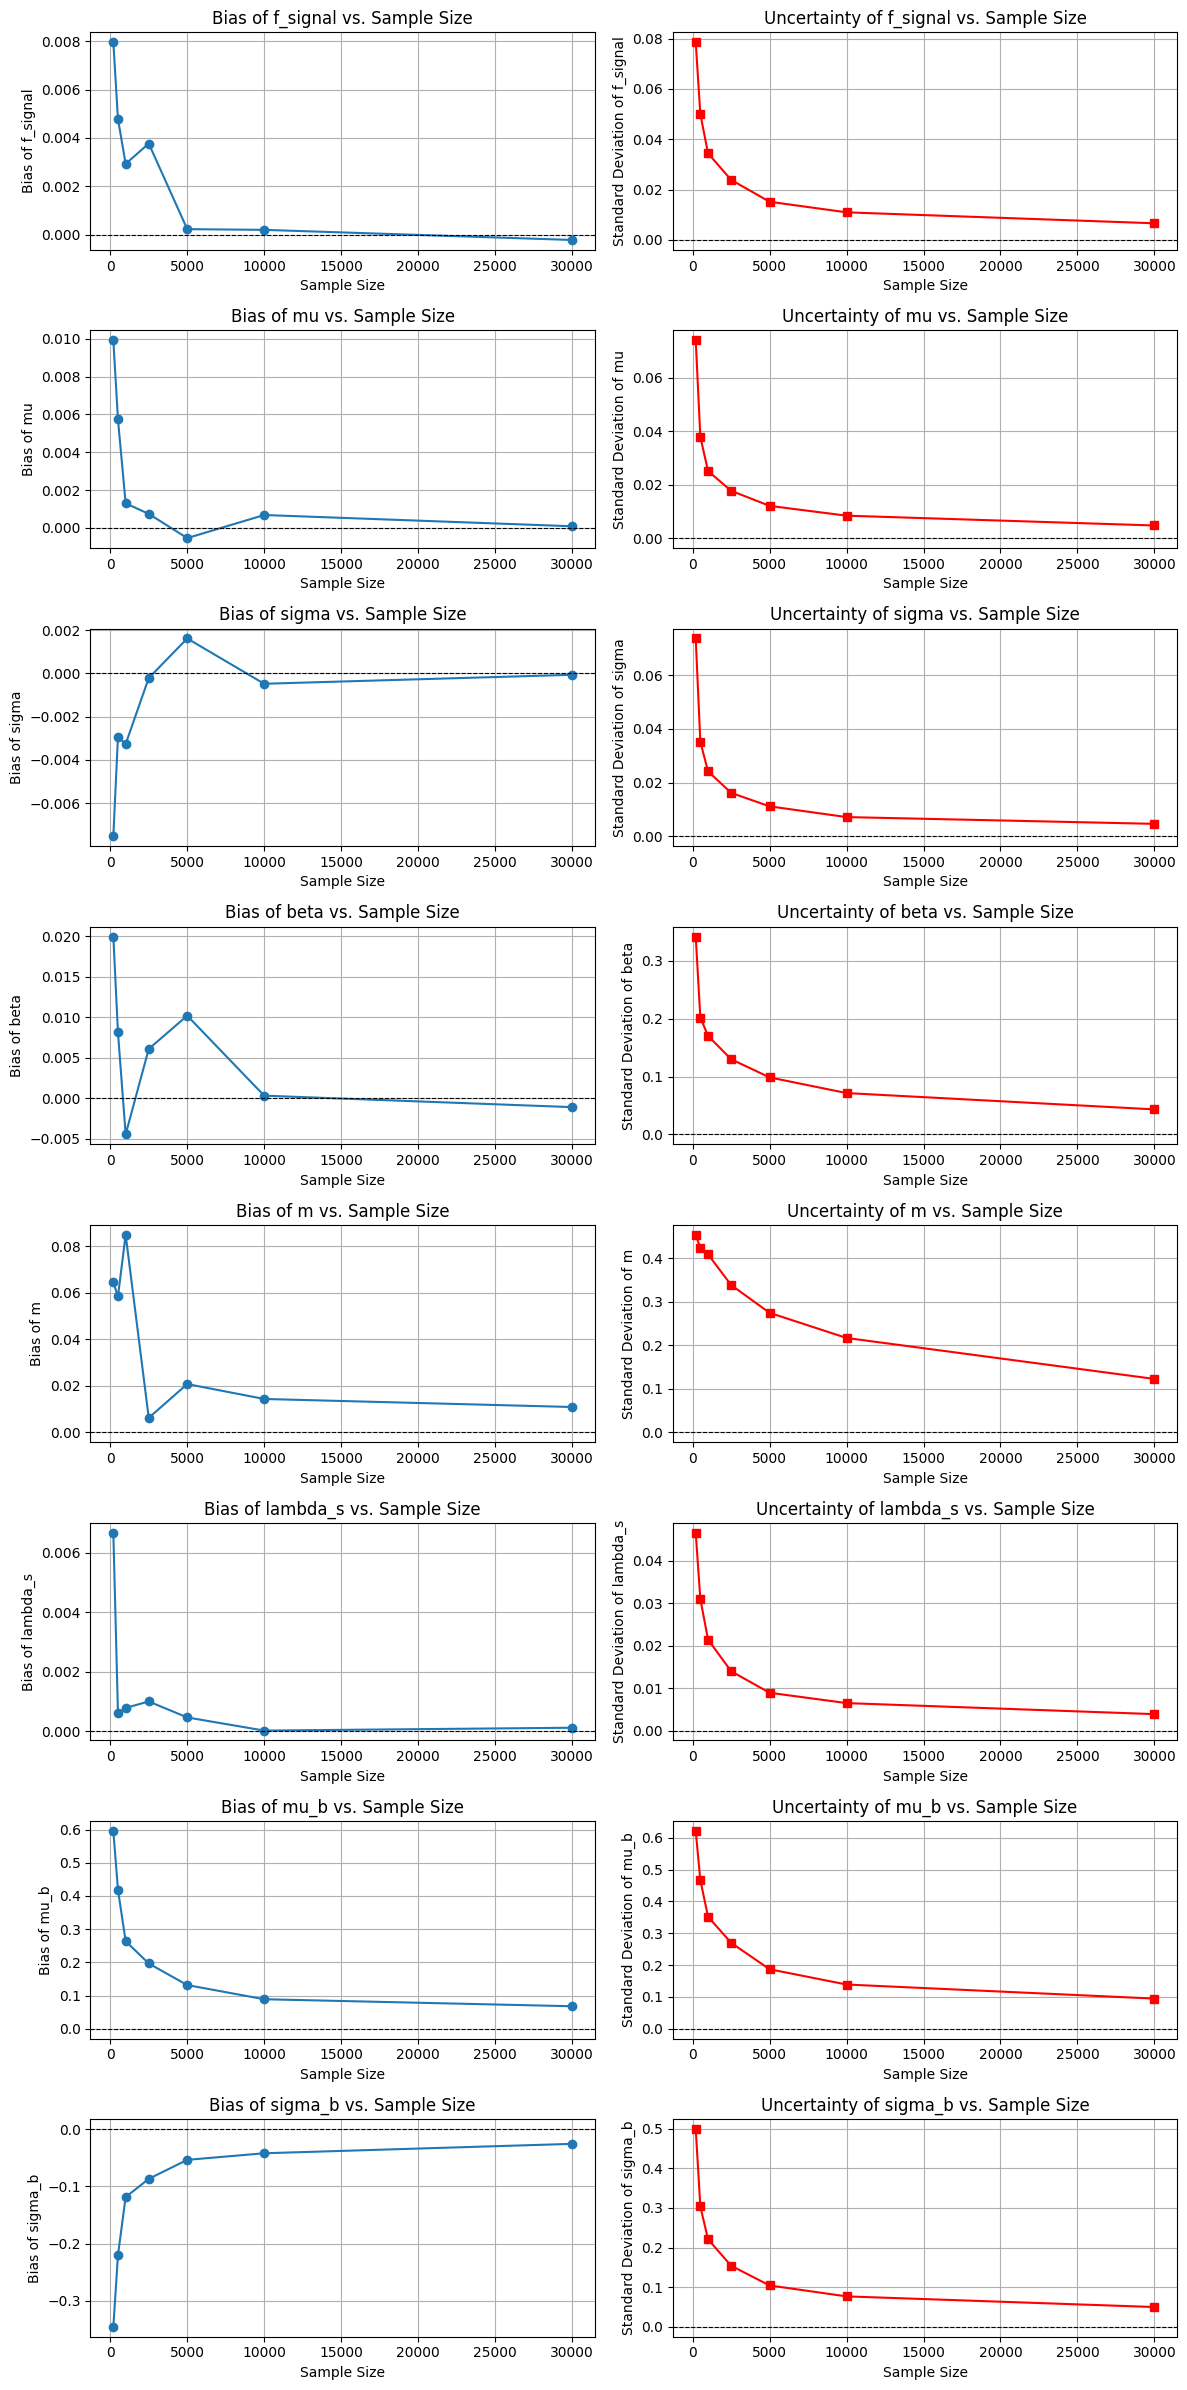

In [16]:
# Visualization: Plot bias and uncertainty for each parameter

with open("results/results_ppf.json", "r") as f:
    results = json.load(f)

sample_sizes = [200, 500, 1000, 2500, 5000, 10000, 30000]
parameters_ = ["f_signal", "mu", "sigma", "beta", "m", "lambda_s", "mu_b", "sigma_b"]

fig, axes = plt.subplots(len(parameters_), 2, figsize=(12, 3 * (len(parameters_) )))

for i, param in enumerate(parameters_):
    # Bias plot
    axes[i, 0].plot(sample_sizes, results[param]["biases"], marker='o')
    axes[i, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # 虚线在 y=0
    axes[i, 0].set_title(f'Bias of {param} vs. Sample Size')
    axes[i, 0].set_xlabel('Sample Size')
    axes[i, 0].set_ylabel(f'Bias of {param}')
    axes[i, 0].grid(True)
    # axes[i, 0].set_ylim(min(results[param]["biases"]) * 1.2, max(results[param]["biases"]) * 1.2)  # 确保显示 y=0

    # Uncertainty plot
    axes[i, 1].plot(sample_sizes, results[param]["stds"], marker='s', color='red')
    axes[i, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # 虚线在 y=0
    axes[i, 1].set_title(f'Uncertainty of {param} vs. Sample Size')
    axes[i, 1].set_xlabel('Sample Size')
    axes[i, 1].set_ylabel(f'Standard Deviation of {param}')
    axes[i, 1].grid(True)
    # axes[i, 1].set_ylim(min(results[param]["stds"]) * 0.8, max(results[param]["stds"]) * 1.2)  # 确保显示 y=0

plt.tight_layout()
plt.show()

# (e) sWeights method for estimating $\lambda$

In [17]:
# Perform MLE fitting for the x component

def density_x(x, N_evs, f_signal, mu, sigma, beta, m): # signal density in x and y
    Ns = N_evs * f_signal
    Nb = N_evs * (1 - f_signal)
    return N_evs, Ns* smodel_x(x, mu, sigma, beta, m) + Nb * bmodel_x(x)

n2ll_x = cost.ExtendedUnbinnedNLL(dataset[0], density_x)  

x_mi = Minuit(n2ll_x, N_evs=N_total, f_signal=0.6, mu=3, sigma=0.3, beta=1, m=1.4)
x_mi.migrad()
x_mi.hesse()
# display(x_mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.836e+06                 │              Nfcn = 158              │
│ EDM = 8.39e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_evs    │ 100.00e3  │  0.32e3   │            │            │         │         │       │
│ 1 │ f_signal │   0.598   │   0.004   │            │            │         │         │       │
│ 2 │ mu       │  2.9954   │  0.0026   │            │            │         │         │       │
│ 3 │ sigma    │  0.3002   │  0.0025   │            │            │         │         │       │
│ 4 │ beta     │   1.029   │   0.023   │            │            │         │         │       │
│ 5 │ m        │   1.33    │   0.06    │            │            │         │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────┐
│          │     N_evs  f_signal        mu     sigma      beta         m │
├──────────┼─────────────────────────────────────────────────────────────┤
│    N_evs │     1e+05        -0     -0e-6     -0e-6        -0     0.000 │
│ f_signal │        -0  1.55e-05     -0e-6      3e-6  0.010e-3 -0.105e-3 │
│       mu │     -0e-6     -0e-6  6.51e-06     -3e-6    -29e-6     48e-6 │
│    sigma │     -0e-6      3e-6     -3e-6  6.27e-06     25e-6    -53e-6 │
│     beta │        -0  0.010e-3    -29e-6     25e-6  0.000505   -1.2e-3 │
│        m │     0.000 -0.105e-3     48e-6    -53e-6   -1.2e-3   0.00376 │
└──────────┴─────────────────────────────────────────────────────────────┘

    PDF normalisations:
	 0 1.000000000007657
	 1 1.0000000000000002
    Integral of w*pdf matrix (should be close to the
                identity):
	[[ 1.00015067e+00 -1.88139181e-04]
	 [-1.40874969e-04  1.00017889e+00]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        | 59838.1703 | 59838.1703 |     0.00% |
	  1        | 40162.0443 | 40162.0443 |     0.00% |
200


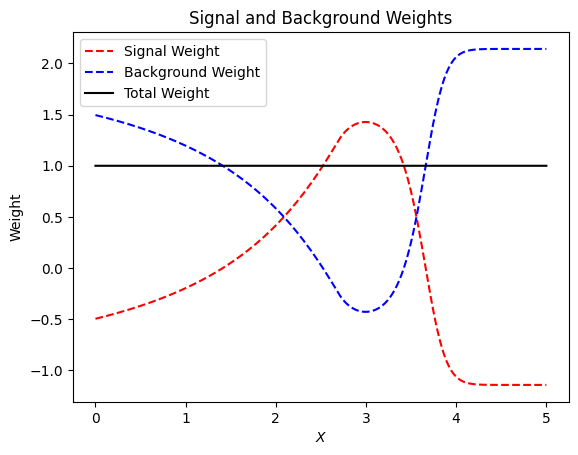

In [18]:
# obtain sweights and plot the signal and background weights

sf = lambda x: smodel_x(x, x_mi.values['mu'], x_mi.values['sigma'], x_mi.values['beta'], x_mi.values['m'])
bf = lambda x: bmodel_x(x)

sy = x_mi.values['N_evs'] * x_mi.values['f_signal']
by = x_mi.values['N_evs'] * (1 - x_mi.values['f_signal'])

sweighter = SWeight(dataset[0], pdfs = [sf, bf], yields = [sy, by], discvarranges=((X_min,X_max),) )

x = np.linspace(*(X_min, X_max), 200)

fig, ax = plt.subplots()
sw = sweighter.get_weight(0,x) # 0 is the signal
bw = sweighter.get_weight(1,x) # 1 is the background
ax.plot(x, sw, 'r--', label='Signal Weight')
ax.plot(x, bw, 'b--', label='Background Weight')
ax.plot(x, sw+bw, 'k-', label='Total Weight')
ax.legend()
ax.set_title('Signal and Background Weights')
ax.set_ylabel('Weight')
ax.set_xlabel('$X$')

print(len(sw))

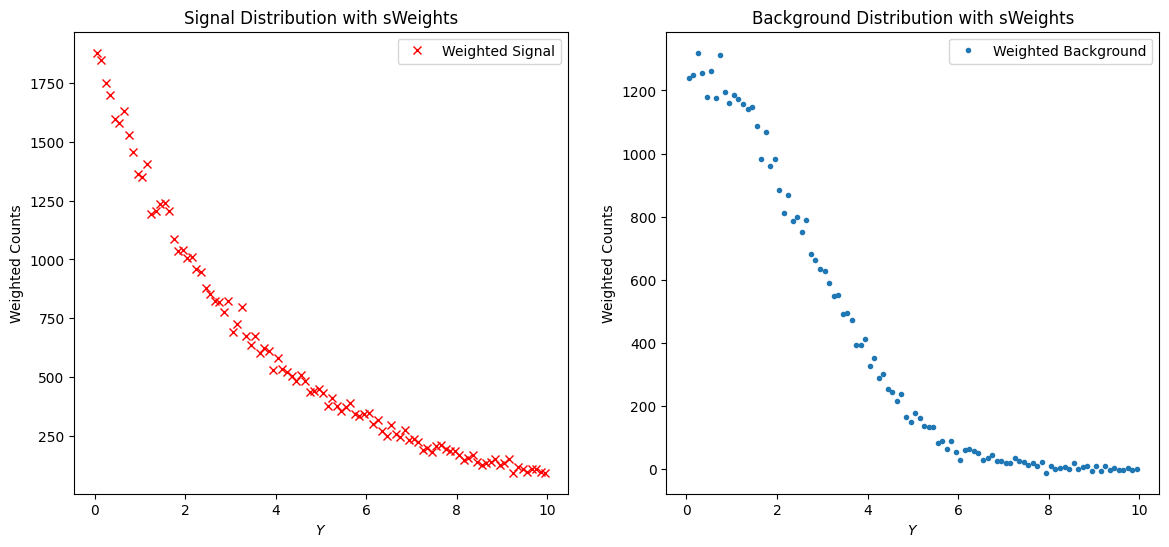

In [19]:
# Apply sWeights to extract signal and background weights for the dataset, plot the weighted distributions

y_range = (Y_min, Y_max)
num_bins = 100

# Apply sWeights to extract signal and background weights for the dataset, function of x
signal_weights = sweighter.get_weight(0, dataset[0])  
background_weights = sweighter.get_weight(1, dataset[0])  

# Compute weighted histograms for signal and background distributions in y
signal_histogram, bin_edges = np.histogram(dataset[1], bins=num_bins, range=y_range, weights=signal_weights)
background_histogram, _ = np.histogram(dataset[1], bins=num_bins, range=y_range, weights=background_weights)

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

 # Create subplots to visualize the weighted distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the weighted signal distribution
axes[0].plot(bin_centers, signal_histogram, 'rx', label='Weighted Signal')
axes[0].legend()
axes[0].set_title('Signal Distribution with sWeights')
axes[0].set_xlabel('$Y$')
axes[0].set_ylabel('Weighted Counts')

# Plot the weighted background distribution
axes[1].plot(bin_centers, background_histogram, '.', label='Weighted Background')
axes[1].legend()
axes[1].set_title('Background Distribution with sWeights')
axes[1].set_xlabel('$Y$')
axes[1].set_ylabel('Weighted Counts')

plt.show()


In [20]:
def negative_log_likelihood(params, bin_centers, observed_counts):
    """
    Negative log-likelihood function for fitting the parameter lambda_s using histogram data.
    
    Args:
        params (list): List containing the parameter lambda_s to be estimated.
        bin_centers (numpy.ndarray): Centers of the histogram bins.
        observed_counts (numpy.ndarray): Observed weighted counts in each histogram bin.
        
    Returns:
        float: The negative log-likelihood value.
    """
    lambda_s = params[0]
    if lambda_s <= 0:  # Ensure lambda_s is positive
        return np.inf

    # Calculate the expected counts in each bin from the model
    expected_pdf = smodel_y(bin_centers, lambda_s)  
    expected_counts = np.sum(observed_counts) * expected_pdf * np.diff(bin_edges)
    
    epsilon = 1e-16
    expected_counts = np.clip(expected_counts, epsilon, None) # avoid log(0)

    # Assuming Poisson stat for the histogram counts
    log_likelihood = np.sum(observed_counts * np.log(expected_counts) - expected_counts)

    return -log_likelihood

In [21]:
# Perform MLE fitting for the y component to estimate lambda_s

sample_sizes = [200, 500, 1000, 2500, 5000, 10000, 30000]
N_toys = 250

lambda_stat = {"means": [], "stds": [], "biases": []}
N_stat = {"means": [], "stds": [], "biases": []}


num_bins = 100
y_range = (Y_min, Y_max)


def expected_counts_integral(xe, lambda_s):
    ''' Calculate the expected counts in each bin from the model.'''
    expon_dist = expon(scale=1/lambda_s)
    signal_cdf = expon_dist.cdf(xe) - expon_dist.cdf(Y_min)
    signal_cdf /= (expon_dist.cdf(Y_max) - expon_dist.cdf(Y_min))
    signal_cdf = np.clip(signal_cdf, 0, 1)  
    expected_signal_cum = N_total * f_signal * signal_cdf
    return expected_signal_cum 


for i, sample_size in tqdm(enumerate(sample_sizes), total=len(sample_sizes), desc="Processing Sample Sizes"):
    lambda_estimates = []
    N_estimates = []

    for _ in range(N_toys):
        dataset = generate_dataset(sample_size, mu, sigma, beta, m, lambda_s, mu_b, sigma_b, f_signal, poiss=True)
        x_data, y_data = dataset[0], dataset[1]

        signal_weights = sweighter.get_weight(0, x_data)
        background_weights = sweighter.get_weight(1, x_data)  

        signal_histogram, bin_edges = np.histogram(
            y_data, bins=num_bins, range=y_range, weights=signal_weights
        )
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        bin_widths = np.diff(bin_edges)

        N_total = np.sum(signal_weights) + np.sum(background_weights)
        N_estimates.append(N_total)

        cost = ExtendedBinnedNLL(signal_histogram, bin_edges, expected_counts_integral)

        minuit_instance = Minuit(cost, lambda_s=0.5)

        minuit_instance.limits["lambda_s"] = (1e-6, None)

        minuit_instance.migrad()

        # if not minuit_instance.valid:
        #     minuit_instance.hesse()

        lambda_hat = minuit_instance.values["lambda_s"]
        lambda_estimates.append(lambda_hat)
        

    lambda_array = np.array(lambda_estimates)
    lambda_mean = np.mean(lambda_array)
    lambda_std = np.std(lambda_array, ddof=1)
    lambda_bias = lambda_mean - lambda_s
    lambda_stat["means"].append(lambda_mean)
    lambda_stat["stds"].append(lambda_std)
    lambda_stat["biases"].append(lambda_bias)

    N_array = np.array(N_estimates)
    N_mean = np.mean(N_array)
    N_std = np.std(N_array, ddof=1)
    N_bias = N_mean - sample_sizes[i]
    N_stat["means"].append(N_mean)
    N_stat["stds"].append(N_std)
    N_stat["biases"].append(N_bias)


results_sweights = {
    "lambda_s": lambda_stat,
    "N_evs": N_stat
}

with open("results/results_sweights.json", "w") as f_results:
    json.dump(results_sweights, f_results, indent=4)
print('saved')

Processing Sample Sizes: 100%|██████████| 7/7 [00:34<00:00,  4.88s/it]

saved


In [22]:
# print the N and lambda_s estimates for each sample size, for each method

# Read results from sWeights JSON file
with open("results/results_sweights.json", "r") as f_results:
    results_sweights = json.load(f_results)

# Extract lambda and N stat from sWeights
lambda_sweights_stat = results_sweights["lambda_s"]
N_sweights_stat = results_sweights["N_evs"]

# Read results from ppf JSON file
with open("results/results_ppf.json", "r") as f_results:
    results_ppf = json.load(f_results)

# Extract lambda and N stat from ppf
lambda_ppf_stat = results_ppf["lambda_s"]
N_ppf_stat = results_ppf["N_evs"]


# ------------------------
# Printing Results for sWeights
# ------------------------
print("sWeights Results:")
print("Sample Size | Lambda Mean Bias | Lambda Std Dev")
print("-" * 50)
for i, sample_size in enumerate(sample_sizes):
    if i < len(lambda_sweights_stat["biases"]):
        lambda_bias = lambda_sweights_stat["biases"][i]
        lambda_std = lambda_sweights_stat["stds"][i]
        print(f"{sample_size:<12} | {lambda_bias:<12.4f} | {lambda_std:<14.4f}")

# Print N_s stat for sWeights
print("\nSample Size | N Mean Bias | Ns Std Dev")
print("-" * 50)
for i, sample_size in enumerate(sample_sizes):
    if i < len(N_sweights_stat["biases"]):
        Ns_bias = N_sweights_stat["biases"][i]
        Ns_std = N_sweights_stat["stds"][i]
        print(f"{sample_size:<12} | {Ns_bias:<8.4f} | {Ns_std:<12.4f}")

# -------------------------
# Printing Results for ppf
# -------------------------
print("\nppf Results:")
print("Sample Size | Lambda Mean Bias | Lambda Std Dev")
print("-" * 50)
for i, sample_size in enumerate(sample_sizes):
    if i < len(lambda_ppf_stat["biases"]):
        lambda_bias = lambda_ppf_stat["biases"][i]
        lambda_std = lambda_ppf_stat["stds"][i]
        print(f"{sample_size:<12} | {lambda_bias:<12.4f} | {lambda_std:<14.4f}")

# Print N_s stat for ppf
print("\nSample Size | N Mean Bias | Ns Std Dev")
print("-" * 50)
for i, sample_size in enumerate(sample_sizes):
    if i < len(N_ppf_stat["biases"]):
        Ns_bias = N_ppf_stat["biases"][i]
        Ns_std = N_ppf_stat["stds"][i]
        print(f"{sample_size:<12} | {Ns_bias:<8.4f} | {Ns_std:<12.4f}")


sWeights Results:
Sample Size | Lambda Mean Bias | Lambda Std Dev
--------------------------------------------------
200          | 0.0032       | 0.0452        
500          | -0.0030      | 0.0316        
1000         | -0.0003      | 0.0217        
2500         | 0.0008       | 0.0134        
5000         | 0.0013       | 0.0096        
10000        | -0.0003      | 0.0066        
30000        | -0.0002      | 0.0039        

Sample Size | N Mean Bias | Ns Std Dev
--------------------------------------------------
200          | -0.3636  | 14.3177     
500          | 2.3011   | 22.5662     
1000         | 1.7821   | 31.8421     
2500         | 1.7294   | 51.9588     
5000         | 1.3229   | 67.0678     
10000        | 5.4416   | 100.1626    
30000        | 12.3412  | 173.2221    

ppf Results:
Sample Size | Lambda Mean Bias | Lambda Std Dev
--------------------------------------------------
200          | 0.0067       | 0.0466        
500          | 0.0006       | 0.0310        
1

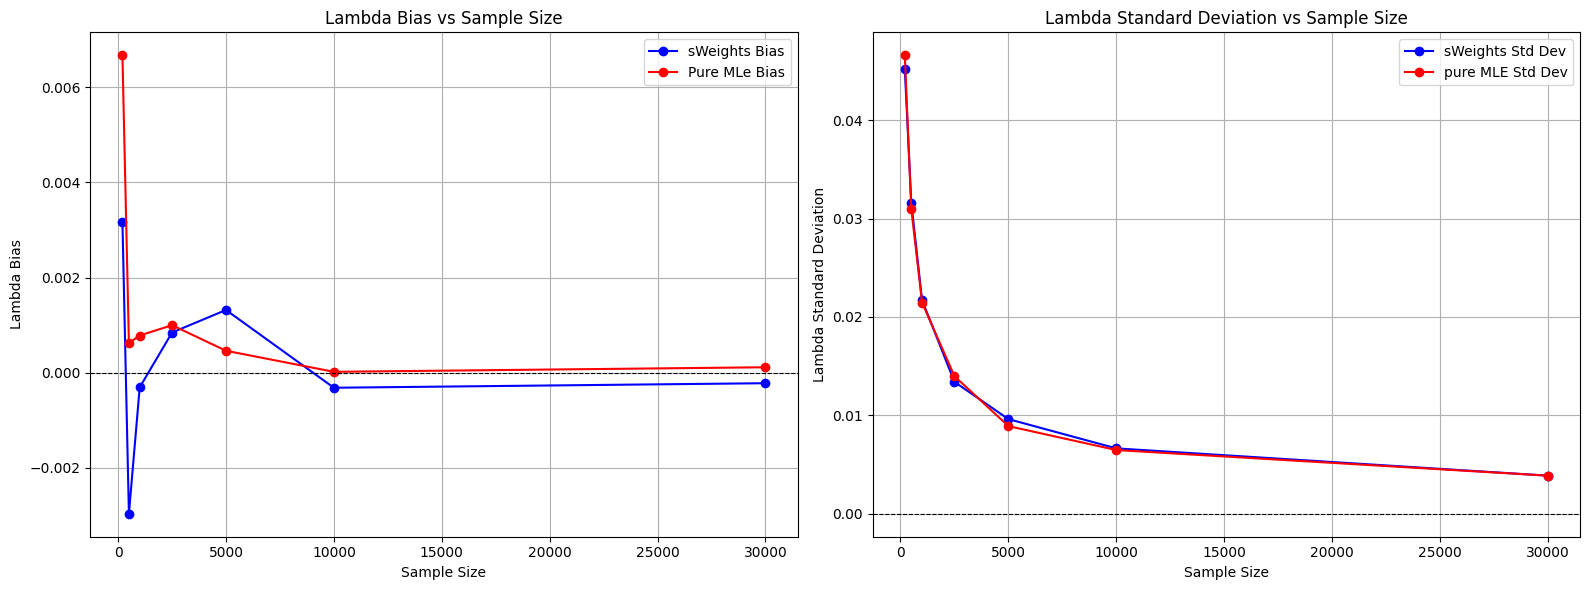

In [23]:
# Plot the bias and standard deviation of lambda for sWeights and ppf

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bias of lambda for sWeights and ppf
axes[0].plot(sample_sizes, lambda_sweights_stat["biases"], label="sWeights Bias", marker='o', linestyle='-', color='blue')
axes[0].plot(sample_sizes, lambda_ppf_stat["biases"], label="Pure MLe Bias", marker='o', linestyle='-', color='red')
axes[0].set_xlabel("Sample Size")
axes[0].set_ylabel("Lambda Bias")
axes[0].set_title("Lambda Bias vs Sample Size")
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Horizontal line at y=0
axes[0].legend()
axes[0].grid(True)

# Plot 2: Standard Deviation of lambda for sWeights and ppf
axes[1].plot(sample_sizes, lambda_sweights_stat["stds"], label="sWeights Std Dev", marker='o', linestyle='-', color='blue')
axes[1].plot(sample_sizes, lambda_ppf_stat["stds"], label="pure MLE Std Dev", marker='o', linestyle='-', color='red')
axes[1].set_xlabel("Sample Size")
axes[1].set_ylabel("Lambda Standard Deviation")
axes[1].set_title("Lambda Standard Deviation vs Sample Size")
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Horizontal line at y=0
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


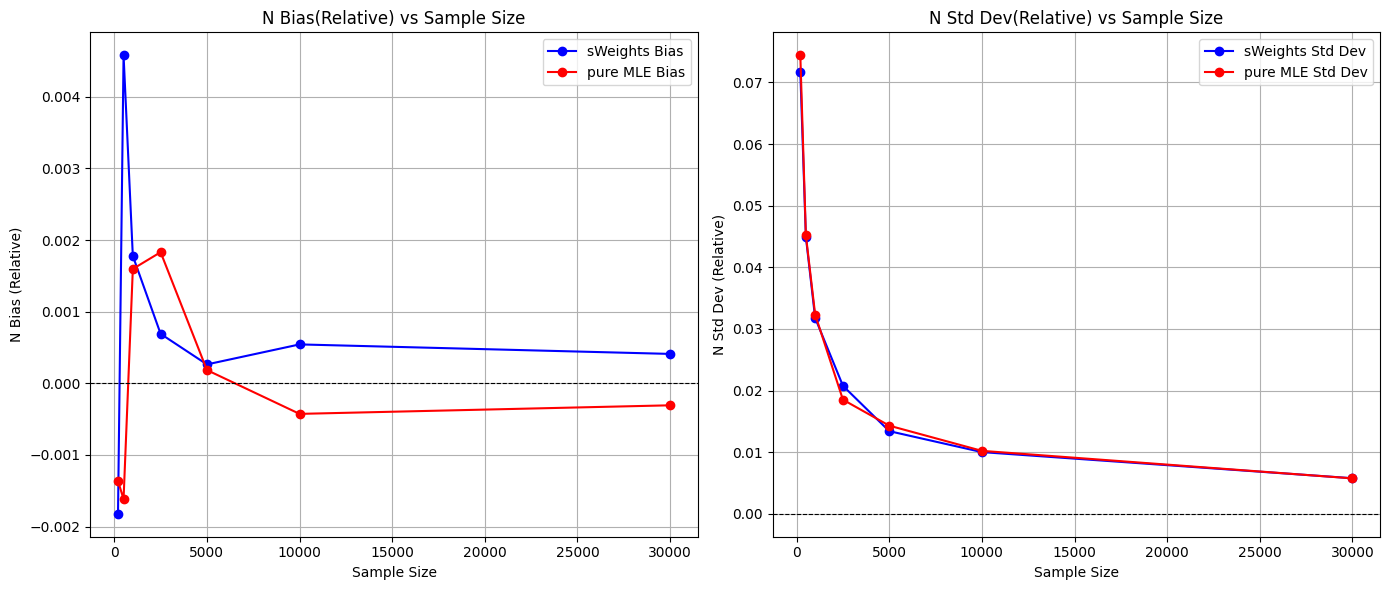

In [24]:
# Plot the bias and standard deviation of N(devided by N) for sWeights and ppf

# Plot 1: Bias of N for sWeights and ppf
fig, axes_N = plt.subplots(1, 2, figsize=(14, 6))  

# Plot the bias of N
axes_N[0].plot(sample_sizes, np.array(N_sweights_stat["biases"]) / np.array(N_sweights_stat['means']), label="sWeights Bias", marker='o', linestyle='-', color='blue')
axes_N[0].plot(sample_sizes, np.array(N_ppf_stat["biases"]) / np.array(N_ppf_stat['means']), label="pure MLE Bias", marker='o', linestyle='-', color='red')
axes_N[0].set_xlabel("Sample Size")
axes_N[0].set_ylabel("N Bias (Relative)")
axes_N[0].set_title("N Bias(Relative) vs Sample Size")
axes_N[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Horizontal line at y=0
axes_N[0].legend()
axes_N[0].grid(True)

# Plot the standard deviation of N
axes_N[1].plot(sample_sizes, np.array(N_sweights_stat["stds"]) / np.array(N_sweights_stat['means']), label="sWeights Std Dev", marker='o', linestyle='-', color='blue')
axes_N[1].plot(sample_sizes, np.array(N_ppf_stat["stds"]) / np.array(N_ppf_stat['means']), label="pure MLE Std Dev", marker='o', linestyle='-', color='red')
axes_N[1].set_xlabel("Sample Size")
axes_N[1].set_ylabel("N Std Dev (Relative)")
axes_N[1].set_title("N Std Dev(Relative) vs Sample Size")
axes_N[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Horizontal line at y=0
axes_N[1].legend()
axes_N[1].grid(True)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
